In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
import pandas as pd
from astroquery.gaia import Gaia
from astropy import units as u
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import gala.coordinates as gc
import astropy.coordinates as coord

from astroquery.vizier import Vizier

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [28]:
styx    = pd.read_csv('styx.csv')
#hermus  = pd.read_csv('hermus.csv')
ngc5466 = pd.read_csv('ngc5466.csv')
acheron = pd.read_csv('acheron.csv')

In [29]:
def color_mag_diagram(table):
    plt.figure(figsize=(10,8))

    plx = table['parallax'].data * u.mas
    plx = plx.to(u.arcsecond)

    dist = 1/plx.value * u.pc
    absG = table['phot_g_mean_mag'] - 5 * np.log10(dist.value/10)

    dist = dist.to(u.kpc)

    pmdec = table['pmdec'].data * u.mas
    pmra  = table['pmra'].data * u.mas
    dec   = table['dec'].data * u.mas

    pm_mag = pmdec.value**2 + pmra.value**2 * np.cos(dec.value)**2
    plt.scatter(table['phot_bp_mean_mag'] - table['phot_rp_mean_mag'], absG, 
                c=pm_mag, s=0.2, vmin=0, vmax=70)
    
    inds = np.where((dist >= 3.5*u.kpc) & (dist <= 3.8*u.kpc))[0]
    plt.scatter(table['phot_bp_mean_mag'][inds] - table['phot_rp_mean_mag'][inds], absG[inds], 
                c=pm_mag[inds], s=2.0, vmin=0, vmax=70)

    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()
    
    return plx, dist, pm_mag

In [30]:
def pos_by_pm(table):
    plx = table['parallax'].data * u.mas
    plx = plx.to(u.arcsecond)

    dist = 1/plx.value * u.pc
    dist = dist.to(u.kpc)

    pmdec = table['pmdec'].data * u.mas
    pmra  = table['pmra'].data * u.mas
    dec   = table['dec'].data * u.mas

    pm_mag = pmdec.value**2 + pmra.value**2 * np.cos(dec.value)**2

    plt.figure(figsize=(8,8))
    plt.scatter(table['ra'], table['dec'], c=pm_mag,
                s=5, vmax=100, vmin=20)

    plt.colorbar()
    plt.show()

In [31]:
def pos_by_dist(table):
    plx = table['parallax'].data * u.mas
    plx = plx.to(u.arcsecond)

    dist = 1/plx.value * u.pc

    dist = dist.to(u.kpc)

    plt.figure(figsize=(8,8))
    plt.scatter(table['ra'], table['dec'], c=dist.value,
                s=1, vmax=20, vmin=15)
    
    inds = np.where((dist >= 18.3*u.kpc) & (dist <= 18.7*u.kpc))[0]
    plt.scatter(table['ra'][inds], table['dec'][inds], c=dist[inds].value,
                s=1, edgecolor='r')

    plt.colorbar()
    plt.show()
    plt.close()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.data is deprecated and will be removed in a future version
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.data is deprecated and will be removed in a future version
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  


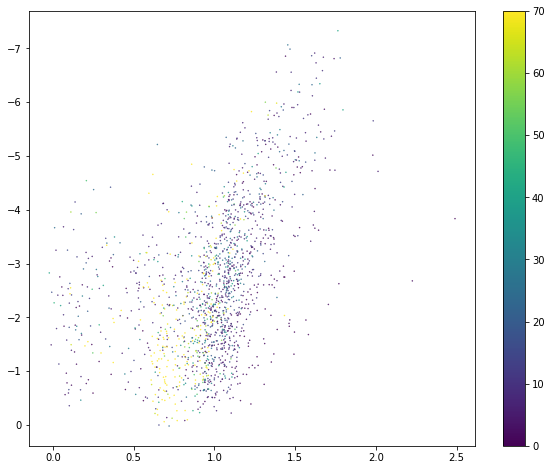

In [35]:
plx, dist, pm_mag = color_mag_diagram(ngc5466)

In [33]:
%matplotlib inline
def initial_search(catalog, pm_mag):
    plt.figure(figsize=(8,8))
    plt.scatter(catalog['ra'], catalog['dec'], c=pm_mag,
                s=6, vmax=50)

    plt.colorbar()
    plt.show()
    plt.close()

    plt.figure(figsize=(10,10))
#    lim = np.where((catalog['ra'] >= 205.2) & (catalog['ra'] <= 205.8) & 
#                   (catalog['dec'] >= 28.2) & (catalog['dec'] <= 28.7))[0]

#    pm_lim = np.where( (catalog['pmra'] >= -1) & (catalog['pmra'] <= 1) & 
#                   (catalog['pmdec'] >= -0.2) & (catalog['pmdec'] <= 0.2) )[0]

    plt.plot(catalog['pmra'], catalog['pmdec'], 'k.', ms=2)
#    plt.plot(ngc5466['pmra'][lim], ngc5466['pmdec'][lim], 'r.', ms=2)
#    plt.plot(ngc5466['pmra'][pm_lim], ngc5466['pmdec'][pm_lim], 'g.', ms=5)
    plt.ylim(-5,3)
    plt.xlim(-5,10)
    plt.show()
    plt.close()

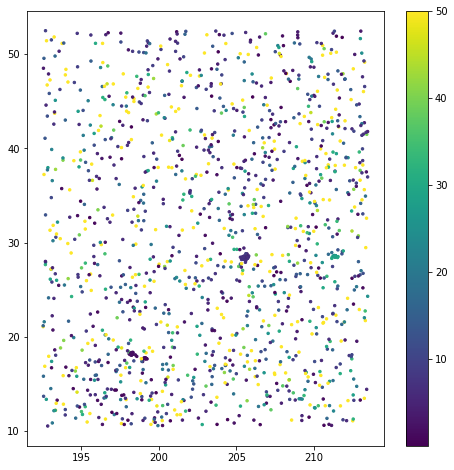

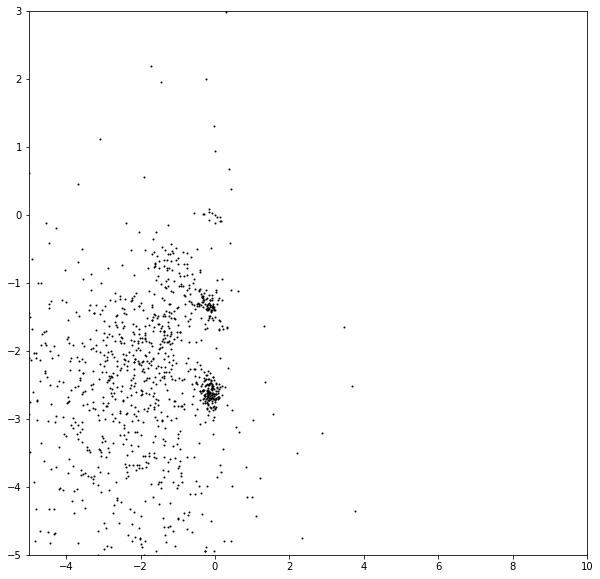

In [36]:
initial_search(ngc5466, pm_mag)

# Getting Colors from 2MASS 

In [8]:
colors = Table(names=['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'g', 'bp', 'rp', 'j', 'h', 'k'])

In [9]:
mass_cols = ['Jmag', 'Hmag', 'Kmag']

for i in range(len(ngc5466['ra'])):
    coordinates = SkyCoord(ngc5466['ra'][i], ngc5466['dec'][i], unit=(u.deg,u.deg))
    try:
        result = Vizier.query_region(coordinates, width="4s",
                                    catalog=["2MASS"])[0]
        mass_colors = result[mass_cols][0]

        row = [coordinates.ra.value, coordinates.dec.value,
               ngc5466['pmra'][i], ngc5466['pmdec'][i], ngc5466['parallax'][i],
               ngc5466['phot_g_mean_mag'][i],
               ngc5466['phot_bp_mean_mag'][i], ngc5466['phot_rp_mean_mag'][i],
               mass_colors[0], mass_colors[1], mass_colors[2]]
        colors.add_row(row)
    except:
        pass

# K-means clustering in ICRS Coordinates

In [10]:
array_icrs = []
for i in range(len(colors['pmra'])):
    motion = np.array([colors['pmra'][i], colors['pmdec'][i], colors['parallax'][i],
                      colors['ra'][i], colors['dec'][i]])
    array_icrs.append(motion)
array_icrs = np.array(array_icrs)

In [11]:
random_state = 240

pred_icrs = KMeans(n_clusters=50, random_state=random_state).fit_predict(array_icrs)

# K-means clustering in Galactic Coordinates

In [12]:
c = coord.ICRS(ra=colors['ra'].data*u.deg, dec=colors['dec'].data*u.deg,
              pm_dec=colors['pmdec'].data*u.mas/u.yr, 
              pm_ra_cosdec=(colors['pmra'].data*np.cos(colors['pmdec'].data)*u.mas/u.yr))
gal = c.transform_to(coord.Galactic)

In [13]:
array_gal = []
for i in range(len(colors['pmra'])):
    motion = np.array([gal.pm_b[i].value, gal.pm_l_cosb[i].value, colors['parallax'][i],
                      gal.l[i].value, gal.b[i].value])
    array_gal.append(motion)
array_gal = np.array(array_gal)

In [14]:
random_state = 240

pred_gal = KMeans(n_clusters=50, random_state=random_state).fit_predict(array_gal)

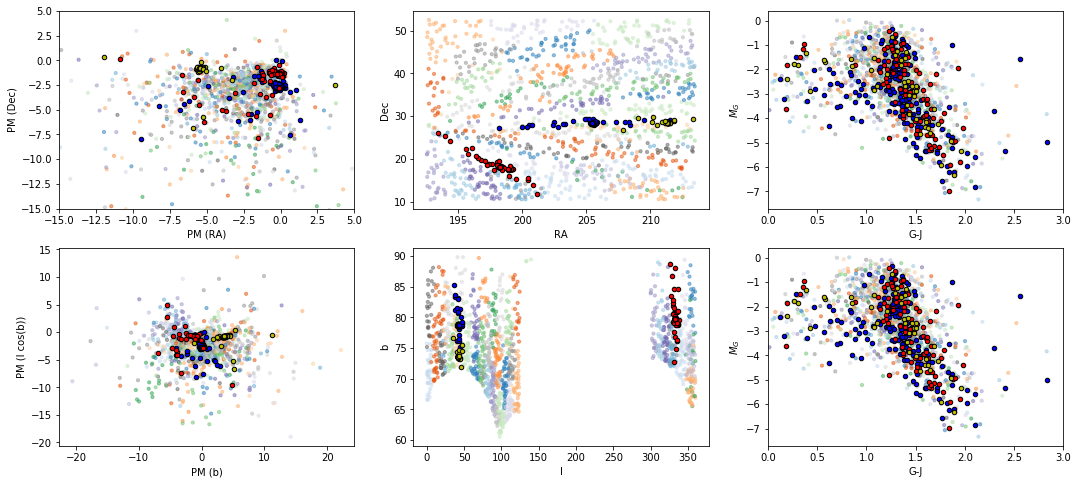

In [37]:
fig, ((ax4, ax5, ax6),(ax1,ax2,ax3)) = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

## GALACTIC COORDINATES ##
im1 = ax1.scatter(gal.pm_b, gal.pm_l_cosb, c=pred_gal, cmap='tab20c', s=10, alpha=0.5)

ind  = np.where(pred_gal==5)[0]
ind1 = np.where(pred_gal==20)[0]
ind2 = np.where(pred_gal==32)[0]

ax1.scatter(gal.pm_b[ind], gal.pm_l_cosb[ind], c='b', cmap='tab20c', s=20, 
           edgecolor='k')
ax1.scatter(gal.pm_b[ind1], gal.pm_l_cosb[ind1], c='r', cmap='tab20c', s=20, 
           edgecolor='k')
ax1.scatter(gal.pm_b[ind2], gal.pm_l_cosb[ind2], c='y', cmap='tab20c', s=20, 
           edgecolor='k')

#ax1.set_ylim(-5,5)
#ax1.set_xlim(-5,5)
ax1.set_xlabel('PM (b)'); ax1.set_ylabel('PM (l cos(b))')


im2 = ax2.scatter(gal.l, gal.b, c=pred_gal, cmap='tab20c', s=10, alpha=0.5)
ax2.scatter(gal.l[ind], gal.b[ind], c='b', cmap='tab20c',
                s=20, edgecolor='k')
ax2.scatter(gal.l[ind1], gal.b[ind1], c='r', cmap='tab20c',
                s=20, edgecolor='k')
ax2.scatter(gal.l[ind2], gal.b[ind2], c='y', cmap='tab20c',
                s=20, edgecolor='k')

ax2.set_xlabel('l'); ax2.set_ylabel('b')

plx = colors['parallax'].data * u.mas
plx = plx.to(u.arcsec)
distance = 1/plx.value * u.pc
distance.to(u.kpc)
mu = 5*(np.log10(distance.value)-1)
gmag = colors['g']
absG = gmag-mu


ax3.scatter(colors['g']-colors['j'], 
            absG, c=pred_gal, cmap='tab20c', s=10, alpha=0.5)
ax3.scatter(colors['g'][ind]-colors['j'][ind], 
            absG[ind], c='b', s=20, edgecolor='k')
ax3.scatter(colors['g'][ind1]-colors['j'][ind1], 
            absG[ind1], c='r', s=20, edgecolor='k')
ax3.scatter(colors['g'][ind2]-colors['j'][ind2], 
            absG[ind2], c='y', s=20, edgecolor='k')

ax3.set_xlim(0,3)
ax3.set_xlabel('G-J'); ax3.set_ylabel('$M_G$')


## ICRS COORDINATES ##

im1 = ax4.scatter(colors['pmra'], colors['pmdec'], c=pred_gal, cmap='tab20c', s=10, alpha=0.5)
ax4.scatter(colors['pmra'][ind], colors['pmdec'][ind], c='b', cmap='tab20c', s=20, 
           edgecolor='k')
ax4.scatter(colors['pmra'][ind1], colors['pmdec'][ind1], c='r', cmap='tab20c', s=20, 
           edgecolor='k')
ax4.scatter(colors['pmra'][ind2], colors['pmdec'][ind2], c='y', cmap='tab20c', s=20, 
           edgecolor='k')
ax4.set_ylim(-15,5)
ax4.set_xlim(-15,5)
ax4.set_xlabel('PM (RA)'); ax4.set_ylabel('PM (Dec)')


im3 = ax5.scatter(colors['ra'], colors['dec'], c=pred_gal, cmap='tab20c', s=10, alpha=0.5)
ax5.scatter(colors['ra'][ind], colors['dec'][ind], c='b', cmap='tab20c',
                s=20, edgecolor='k')
ax5.scatter(colors['ra'][ind1], colors['dec'][ind1], c='r', cmap='tab20c',
                s=20, edgecolor='k')
ax5.scatter(colors['ra'][ind2], colors['dec'][ind2], c='y', cmap='tab20c',
                s=20, edgecolor='k')
ax5.set_xlabel('RA'); ax5.set_ylabel('Dec')



ax6.scatter(colors['g']-colors['j'], 
            absG, c=pred_gal, cmap='tab20c', s=10, alpha=0.5)
ax6.scatter(colors['g'][ind]-colors['j'][ind], 
            absG[ind], c='b', s=20, edgecolor='k')
ax6.scatter(colors['g'][ind1]-colors['j'][ind1], 
            absG[ind1], c='r', s=20, edgecolor='k')
ax6.scatter(colors['g'][ind2]-colors['j'][ind2], 
            absG[ind2], c='y', s=20, edgecolor='k')
#ax3.set_ylim(-7,0)
ax6.set_xlim(0,3)
ax6.set_xlabel('G-J'); ax6.set_ylabel('$M_G$')


plt.show()
#plt.subplots_adjust()
#plt.savefig('cluster_testing.png', bbox_inches='tight', dpi=250)
plt.close()

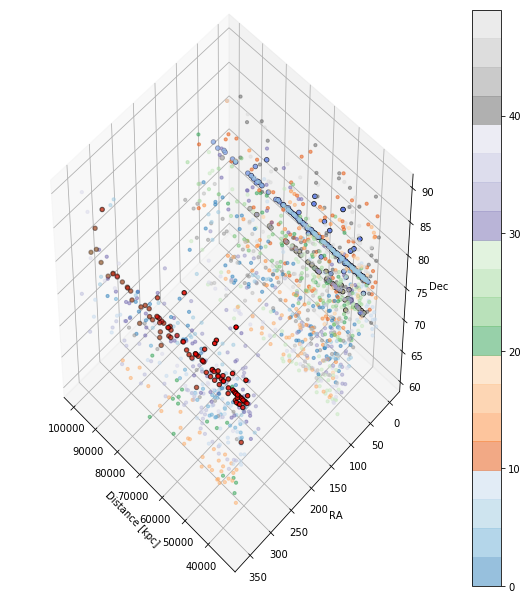

In [38]:
## 3D FIGURE ##

fig = plt.figure(figsize=(8,8))
ax  = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
im  = ax.scatter(1/(colors['parallax']*u.mas).to(u.arcsec).value, gal.l, gal.b,
               c=pred_gal, s=10, cmap='tab20c', alpha=0.5)

ax.scatter(1/(colors['parallax'][ind]*u.mas).to(u.arcsec).value, gal.l[ind], gal.b[ind],
               c='b', s=20, edgecolor='k')

ax.scatter(1/(colors['parallax'][ind1]*u.mas).to(u.arcsec).value, gal.l[ind1], gal.b[ind1],
               c='r', s=20, edgecolor='k')

ax.scatter(1/(colors['parallax'][ind2]*u.mas).to(u.arcsec).value, gal.l[ind2], gal.b[ind2],
               c='y', s=20, edgecolor='k')

ax.set_xlabel('Distance [kpc]')
ax.set_ylabel('RA')
ax.set_zlabel('Dec')
plt.colorbar(im)
plt.show()